In [9]:
# import the necessary packages
import numpy as np
import imutils
import cv2
import os
import skimage
import PIL
import matplotlib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imutils import paths

from sklearn import metrics
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [10]:
# grab the list of images that we'll be describing
# print("[INFO] describing images...")
imagePaths = list(paths.list_images("."+os.sep+"train_vega"))

# initialize the raw pixel intensities matrix, the features matrix, and labels list
rawImages = []
features = []
labels = []
images=[]

In [11]:
#Function for the images treatment
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist(image, [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])
    
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)

    # otherwise, perform "in place" normalization in OpenCV 3
    else:
        cv2.normalize(hist, hist)
        
    # return the flattened histogram as the feature vector
    return hist.flatten()

def create_distortion(image,number):
    images = []
    for i in range(1,number):
        images.append(np.uint8(image + i*0.5* image.std() * np.random.random(image.shape)))
    return images

def image_treatment(image,label):
    rawImages.append(image_to_feature_vector(image))
    features.append(extract_color_histogram(image))
    labels.append(label)

In [12]:
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    
    image = cv2.imread(imagePath)
    tab_image = create_distortion(image,11)
    
    image_flip = cv2.flip(image,1)
    tab_image_flip = create_distortion(image_flip,11)
   
    images = tab_image + tab_image_flip
    images.append(image)
    images.append(image_flip)
    
    label = imagePath.split(os.path.sep)[-1].split(".")[0]

    for im in images:
        image_treatment(im,label)

    # show an update every 10 images
    if i > 0 and i % 10 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
print("Done")

[INFO] processed 10/33
[INFO] processed 20/33
[INFO] processed 30/33
Done


In [13]:
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
    features, labels, test_size=0.25, random_state=42)

In [44]:
svm_kernel = ["linear","poly","rbf","sigmoid"]
# train and evaluate a SVM classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy")
scores_rawpixel = [];
for k in range(len(svm_kernel)) :
    model = SVC(kernel=svm_kernel[k], C=1, random_state=0)
    model.fit(trainRI, trainRL)
    RL_pred = model.predict(testRI)
    acc = model.score(testRI, testRL)
    scores_rawpixel.append(acc)
    print("[INFO] raw pixel accuracy for",svm_kernel[k],"kernel:{:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy
[INFO] raw pixel accuracy for linear kernel:86.81%
[INFO] raw pixel accuracy for poly kernel:86.26%
[INFO] raw pixel accuracy for rbf kernel:70.33%
[INFO] raw pixel accuracy for sigmoid kernel:70.33%


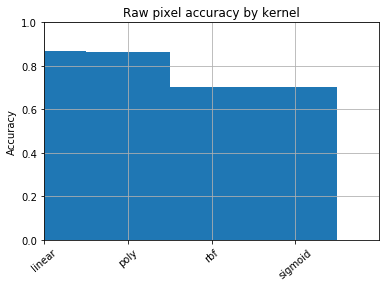

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pylab

fig = plt.figure()

x = [0,1,2,3]
height = scores_rawpixel
width = 1
BarName = ["linear","poly","rbf","sigmoid"]

plt.bar(x, height, width)

plt.xlim(0,4)
plt.ylim(0,1)
plt.grid()

plt.ylabel('Accuracy')
plt.title('Raw pixel accuracy by kernel')

pylab.xticks(x, BarName, rotation=40)

plt.savefig('SimpleBar.png')
plt.show()

In [51]:
# train and evaluate a SVM classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy")
scores_hist = [];
for k in range(len(svm_kernel)) :
    model = SVC(kernel=svm_kernel[k], C=1, random_state=0)
    model.fit(trainFeat, trainLabels)
    Labels_pred = model.predict(testFeat)
    acc = model.score(testFeat, testLabels)
    scores_hist.append(acc)
    print("[INFO] raw pixel accuracy for",svm_kernel[k],"kernel:{:.2f}%".format(acc * 100))

[INFO] evaluating histogram accuracy
[INFO] raw pixel accuracy for linear kernel:70.33%
[INFO] raw pixel accuracy for poly kernel:70.33%
[INFO] raw pixel accuracy for rbf kernel:70.33%
[INFO] raw pixel accuracy for sigmoid kernel:70.33%


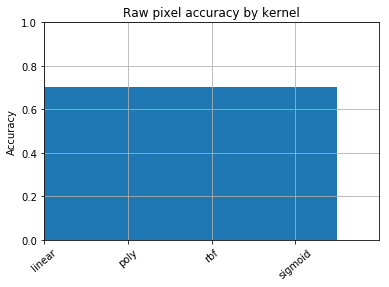

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pylab

fig = plt.figure()

x = x = [0,1,2,3]
height = scores_hist
width = 1
BarName = ["linear","poly","rbf","sigmoid"]

plt.bar(x, height, width)

plt.xlim(0,4)
plt.ylim(0,1)
plt.grid()

plt.ylabel('Accuracy')
plt.title('Raw pixel accuracy by kernel')

pylab.xticks(x, BarName, rotation=40)

plt.savefig('SimpleBar.png')
plt.show()

In [56]:
# evaluation modèle SVM
print (metrics.classification_report(testRL, RL_pred))
print ("---------------------------------------------------------------------------")
print (metrics.classification_report(testLabels, Labels_pred))

             precision    recall  f1-score   support

       Ankh       0.70      1.00      0.83       128
     bouche       0.00      0.00      0.00        54

avg / total       0.49      0.70      0.58       182

---------------------------------------------------------------------------
             precision    recall  f1-score   support

       Ankh       0.70      1.00      0.83       128
     bouche       0.00      0.00      0.00        54

avg / total       0.49      0.70      0.58       182



C:\Users\Sarah\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
